In [1]:
import sys
import os
import torch
import numpy as np
from ast_models import ASTModel
import soundfile as sf
import matplotlib.pyplot as plt
import torchaudio

# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")
test_input = fbank_features

# normalize fbank features
dataset_mean=-3.6925695
dataset_std=4.020388
test_input = (test_input - dataset_mean) / (2 * dataset_std)

# add batch dimension
test_input = test_input.unsqueeze(0)
print(f"Shape of fbank features: {test_input.shape}")

# # duplicate input tensor to get a batch of 2
# test_input = torch.cat((test_input, test_input), 0)
# print(f"Shape of dublicated fbank features: {test_input.shape}")

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])
Shape of fbank features: torch.Size([1, 998, 128])


In [2]:
model = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=True)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014/models/audio_model.120.pth'))
model = model.module
model.to('cpu')
model.eval()
print(next(model.parameters()).device)  # Should print 'cpu'

pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
cpu


In [4]:
import sys
import os
import torch
import numpy as np
from ast_models import ASTModel

## average token

In [5]:
model50 = ASTModel(fshape=128, tshape=2, fstride=128, tstride=2, input_fdim=128, input_tdim=998, model_size='base', pretrain_stage=False, load_pretrained_mdl_path='/home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014/models/audio_model.73.pth')

now load a SSL pretrained models from /home/bosfab01/SpeakerVerificationBA/pretraining/exp/pretrained-base-f128-t2-b24-lr1e-4-m400-pretrain_joint-asli-original-20240418-211014/models/audio_model.73.pth
pretraining patch split stride: frequency=128, time=2
pretraining patch shape: frequency=128, time=2
pretraining patch array dimension: frequency=1, time=499
pretraining number of patches=499
fine-tuning patch split stride: frequncey=128, time=2
fine-tuning number of patches=499


In [6]:
# test finetuningavgtok()) function
with torch.no_grad():
    output = model50(test_input, task='ft_avgtok')

torch.Size([1, 998, 128])
torch.Size([1, 527])
tensor(0.9921)
tensor(-1.5235)
tensor(1.8776)
tensor(-1.6079)


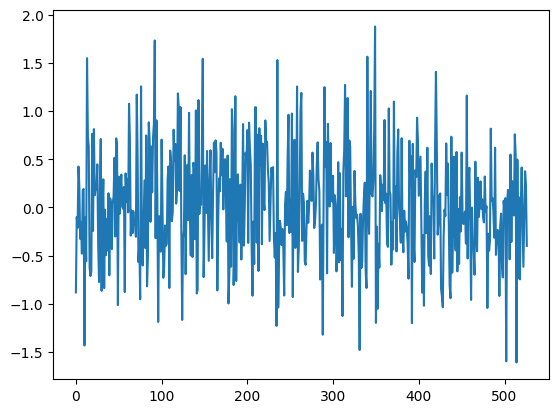

In [7]:
# compare input and output
print(test_input.shape)
print(output.shape)
print(torch.max(test_input))
print(torch.min(test_input))
print(torch.max(output))
print(torch.min(output))

# plot output
plt.plot(output.squeeze().cpu().numpy())


## folding and umfolding

In [8]:
# torch.nn.Unfold(kernel_size=(4, 2), stride=(4, 2)) corresponds to torch.nn.Unfold(kernel_size=(128, 2), stride=(128, 2)) 
# input shape:  torch.Size([1, 1, 4, 14]) corresponds to torch.Size([1, 1, 128, 998])
# unfolded input shape (after transposing dimensions 1 and 2):  torch.Size([1, 7, 8]) corresponds to torch.Size([1, 499, 256])

import torch
unfold = torch.nn.Unfold(kernel_size=(4, 2), stride=(4, 2))

# inverse operation of Unfold
fold = torch.nn.Fold(output_size=(4, 14), kernel_size=(4, 2), stride=(4, 2)) # corresponds to torch.nn.Fold(output_size=(128, 998), kernel_size=(128, 2), stride=(128, 2))

# Define the input tensor
input_tensor = torch.tensor([[[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
                                [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
                                [29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42],
                                [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]]]], dtype=torch.float32)

print("Input tensor:")
print("shape: ", input_tensor.shape)
print(input_tensor)

# Apply the Unfold operation
input = unfold(input_tensor)

print("\nInput tensor unfolded:")
print("shape: ", input.shape)
print(input)

# Transpose the dimensions 1 and 2
input = input.transpose(1, 2)

print("\nInput tensor unfolded (transposed):")
print("shape: ", input.shape)
print(input)

# Transpose back to original shape
input = input.transpose(1, 2)

print("\nInput tensor unfolded (transposed back):")
print("shape: ", input.shape)
print(input)

# Apply the Fold operation
output_tensor = fold(input)
print("\nOutput tensor folded:")
print("shape: ", output_tensor.shape)
print(output_tensor)



Input tensor:
shape:  torch.Size([1, 1, 4, 14])
tensor([[[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.],
          [15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.],
          [29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.],
          [43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.]]]])

Input tensor unfolded:
shape:  torch.Size([1, 8, 7])
tensor([[[ 1.,  3.,  5.,  7.,  9., 11., 13.],
         [ 2.,  4.,  6.,  8., 10., 12., 14.],
         [15., 17., 19., 21., 23., 25., 27.],
         [16., 18., 20., 22., 24., 26., 28.],
         [29., 31., 33., 35., 37., 39., 41.],
         [30., 32., 34., 36., 38., 40., 42.],
         [43., 45., 47., 49., 51., 53., 55.],
         [44., 46., 48., 50., 52., 54., 56.]]])

Input tensor unfolded (transposed):
shape:  torch.Size([1, 7, 8])
tensor([[[ 1.,  2., 15., 16., 29., 30., 43., 44.],
         [ 3.,  4., 17., 18., 31., 32., 45., 46.],
         [ 5.,  6., 19., 20.